
# 🧬 Logistic Regression: Breast Cancer Diagnosis
---
**프로젝트**: 유방암(Malignant) 예측 및 임상적 위험 인자 분석

## 📌 분석 개요 및 목적
본 리포트는 단순한 정확도(Accuracy) 경쟁을 지양하고, 실제 의료 현장에서 의사결정을 지원할 수 있는 **'설명 가능하고 신뢰할 수 있는 분석'** 을 구축하는 과정을 담았습니다.

### 🔍 분석 파이프라인
1.  **Deep EDA & Statistical Testing**:
    *   단순 시각화를 넘어, T-test(Welch's t-test)를 통해 암과 정상을 구분하는 **'통계적으로 유의미한 변수'** 를 선별합니다.
2.  **Advanced Preprocessing (VIF Verification)**:
    *   다중공선성(Multicollinearity)은 회귀분석의 결과값을 불안정하게 합니다. 상관계수 기반 제거뿐만 아니라, **VIF(분산 팽창 요인) 사후 검증** 을 통해 변수의 독립성을 수학적으로 보장합니다.
3.  **Robust Modeling**:
    *   **Class Weight Adjustment**: 불균형한 암 데이터의 특성을 고려해 Loss Function을 조정합니다.
    *   **Standardized Coefficients**: 모든 변수를 스케일링하여, 변수 간 영향력을 공정하게 비교합니다.
4.  **Reliability & Diagnosis**:
    *   **Learning Curve**: 데이터 부족 및 과적합 여부를 진단합니다.
    *   **Calibration Curve**: 모델이 예측한 확률이 실제 발병률과 일치하는지(신뢰도) 검증합니다.
5.  **Decision Boundary Visualization**:
    *   PCA를 통해 고차원 데이터를 2차원으로 축소하여, 모델의 선형 분리 성능을 시각적으로 확인합니다.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.metrics import (classification_report, roc_curve, auc, 
                             precision_recall_curve, confusion_matrix, f1_score, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')



## 1. 데이터 로드 및 구조 파악
가장 먼저 타겟(Target)의 분포를 확인해야 합니다. 
암 데이터는 전형적으로 **불균형(Imbalanced)** 합니다. 비율이 깨져 있다면 모델은 다수 클래스(정상)만 맞추려 할 것입니다.
- **Target 정의**: 
    - 원본: 0(Malignant), 1(Benign)
    - **변경**: 1(Malignant/암), 0(Benign/정상) -> *우리가 찾고자 하는 '암'을 1로 두는 것이 직관적입니다.*


=== Target Distribution ===
target
0    0.627417
1    0.372583
Name: proportion, dtype: float64


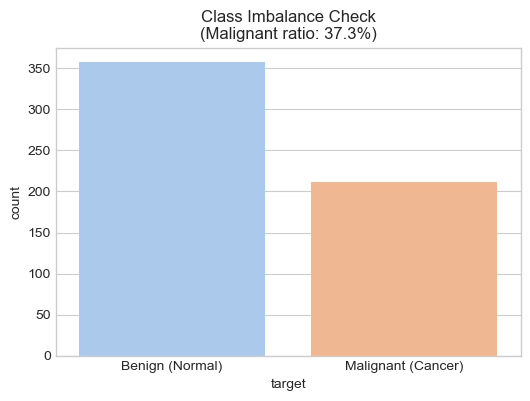

In [2]:

def load_data():
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    # Target: 0(Malignant) -> 1, 1(Benign) -> 0 으로 변환
    df['target'] = (data.target == 0).astype(int) 
    return df

df = load_data()

# 클래스 불균형 비율 계산
target_counts = df['target'].value_counts(normalize=True)
print("=== Target Distribution ===")
print(target_counts)

# 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='pastel')
plt.title(f'Class Imbalance Check\n(Malignant ratio: {target_counts[1]*100:.1f}%)')
plt.xticks([0, 1], ['Benign (Normal)', 'Malignant (Cancer)'])
plt.show()


### 1-1. 데이터 구조
- 컬럼 개수: 29 (타겟은 제외)
- 총 데이터 수: 569
- 결측치 여부: X
- 실수형 데이터 및 범주형 결과 예측

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5


## 2. 심층 EDA: 통계적 가설 검정 (T-test)
단순히 그래프만 보는 것은 주관적이고 느낌적인 영역입니다. **"악성 종양과 양성 종양 간에 해당 변수의 평균 차이가 통계적으로 유의한가?"** 를 검정합니다.
- **귀무가설($H_0$)**: 악성 그룹과 양성 그룹의 변수 평균은 같다.
- **대립가설($H_1$)**: 악성 그룹과 양성 그룹의 변수 평균은 다르다. (이 변수는 암을 구별하는 데 유용하다)

**P-value < 0.05** 인 변수들만 선별하여 모델링에 사용하는 것이 노이즈를 줄이는데 유용합니다.
- T-Statistic (T 통계량): 두 그룹(암 vs 정상) 간의 평균 차이가 클수록, 그룹 내 분산이 작을수록 값이 증가


In [4]:

def perform_ttest(df):
    malignant = df[df['target'] == 1]
    benign = df[df['target'] == 0]

    results = []
    for col in df.columns:
        if col == 'target': continue

        # t-test 수행 (등분산 가정 X -> Welch's t-test)
        t_stat, p_val = stats.ttest_ind(malignant[col], benign[col], equal_var=False)

        results.append({
            'Feature': col,
            'T-Statistic': t_stat,
            'P-Value': p_val,
            'Mean_Malignant': malignant[col].mean(),
            'Mean_Benign': benign[col].mean()
        })

    results_df = pd.DataFrame(results).sort_values(by='P-Value')
    return results_df

ttest_results = perform_ttest(df)

print("=== Top 5 Most Distinguishing Features (High T-Statistic) ===")
display(ttest_results.head(5))


=== Top 5 Most Distinguishing Features (High T-Statistic) ===


,Feature,T-Statistic,P-Value,Mean_Malignant,Mean_Benign
27,worst concave points,29.117659,1.061454e-96,0.182237,0.074444
22,worst perimeter,25.332210,1.032730e-72,141.370330,87.005938
7,mean concave points,24.844810,3.127316e-71,0.087990,0.025717
20,worst radius,24.829745,3.556557e-71,21.134811,13.379801
2,mean perimeter,22.935314,1.023141e-66,115.365377,78.075406


### 2-1. T-Statistic 및 p-value 해석
#### 1. **"통계적으로 유의하다" ≠ "예측 성능이 좋다"**  
P-value가 0.05보다 작다는 건 **"두 그룹(암 vs 정상)의 평균이 다르긴 다르다"**는 뜻일 뿐입니다. 하지만 **"얼마나 명확하게 구분되는가?"** 는 별개의 문제입니다.

1등 (worst concave points): 암환자와 정상인의 분포가 확연히 갈라져 있어(T-stat: 29.11) 겹치는 구간이 거의 없습니다. 이것 하나만으로도 암을 상당히 잘 맞춥니다.

하위권 (texture error 등): P-value는 0.05보다 작아서 "차이가 있다"고 나오지만, 실제로는 분포가 많이 겹칩니다. (T-stat이 낮음). 이런 변수를 모델에 넣으면 오히려 노이즈(Noise)가 되어 헷갈리게 만들 수 있습니다.  

#### 2. **"정보의 중복" (Multicollinearity의 또 다른 관점)**
상위권 변수들을 자세히 보세요.

2등: worst perimeter (둘레)

4등: worst radius (반지름)

5등: mean perimeter (평균 둘레)

6등: mean radius (평균 반지름)

이들은 이름만 다를 뿐, 사실상 "세포가 크다"는 똑같은 이야기를 하고 있습니다.
P-value가 모두 낮다고 해서 이들을 전부 다 모델에 넣으면, 모델은 "크다"는 정보만 4번 중복해서 듣게 됩니다. 이는 모델 과적합(Overfitting)의 지름길입니다.

따라서 T-statistic이 가장 높은 대표 주자(2등: worst perimeter) 하나만 남기고, 나머지는 쳐내는 것이 현명한 전략입니다.

#### 3. **"비용 효율성" (Cost-Efficiency)**
실제 병원 현장을 생각해 봅시다.

30가지 검사를 다 해서 98% 정확도를 내는 것보다,

핵심 지표 5개만 검사해서 97.5% 정확도를 내는 것이 훨씬 빠르고, 저렴하고, 효율적입니다.

상위 5개를 뽑는 행위는 단순한 랭킹 매기기가 아니라, **"최소한의 정보로 최대의 효율을 내기 위한 Feature Selection의 첫걸음"** 입니다.

💡 결론
P-value가 다 낮다고 다 쓰는 게 아닙니다.
**"필요한 특성(High T-stat)"** 을 골라내고, **"중복되는 특성"** 을 쳐내기 위해 순위를 매기는 것입니다.

In [5]:
ttest_results

,Feature,T-Statistic,P-Value,Mean_Malignant,Mean_Benign
27,worst concave points,29.117659,1.061454e-96,0.182237,0.074444
22,worst perimeter,25.332210,1.032730e-72,141.370330,87.005938
7,mean concave points,24.844810,3.127316e-71,0.087990,0.025717
20,worst radius,24.829745,3.556557e-71,21.134811,13.379801
2,mean perimeter,22.935314,1.023141e-66,115.365377,78.075406
0,mean radius,22.208798,1.684459e-64,17.462830,12.146524
26,worst concavity,19.595726,9.852484e-59,0.450606,0.166238
6,mean concavity,20.332425,3.742121e-58,0.160775,0.046058
23,worst area,20.570814,4.937924e-54,1422.286321,558.899440
3,mean area,19.640990,3.284366e-52,978.376415,462.790196



### 2-2. 주요 변수 간의 경계 확인 (Pairplot)
통계적으로 가장 차이가 큰(T-statistic이 높은) 상위 3개 변수 간의 관계를 시각화합니다.
데이터가 선형적으로 분리 가능한지 눈으로 확인할 수 있습니다.


#### 상위 3개의 피처 분리도 확인

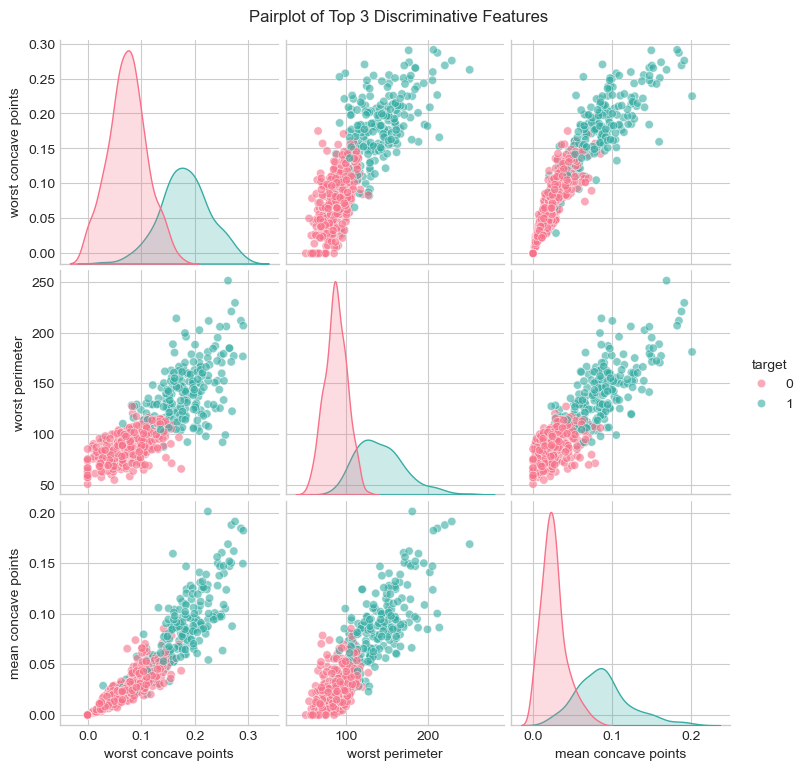

In [6]:

top_3_features = ttest_results['Feature'].head(3).tolist()
sns.pairplot(df, vars=top_3_features, hue='target', palette='husl', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top 3 Discriminative Features', y=1.02)
plt.show()


#### 하위 3개의 피처 분리도 확인

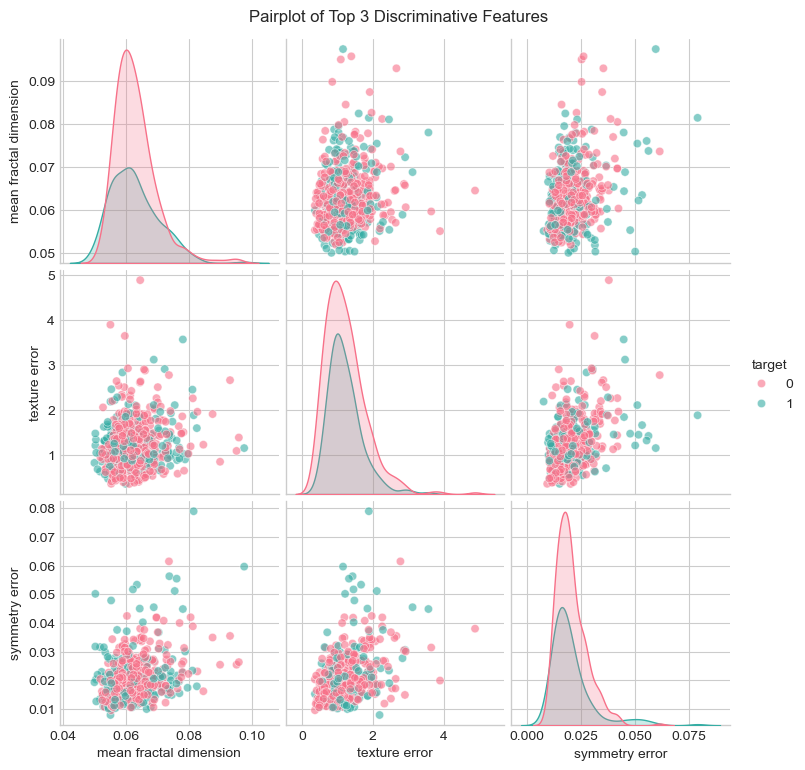

In [7]:

bottom_3_features = ttest_results['Feature'].tail(3).tolist()
sns.pairplot(df, vars=bottom_3_features, hue='target', palette='husl', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top 3 Discriminative Features', y=1.02)
plt.show()



## 3. 전처리: 다중공선성 제거 및 사후 검증 (VIF Check)
**다중공선성(Multicollinearity)** 은 회귀계수의 분산을 팽창시켜 해석을 불가능하게 만듭니다. 
1. **Correlation Filtering**: 상관계수 0.9 이상인 변수 중 하나를 제거합니다.
2. **Post-hoc VIF Check**: 필터링 후에도 VIF가 높은 변수가 남아있는지 확인합니다. (VIF < 10 목표)


In [8]:

# 1. 상관계수 기반 변수 제거 함수
def remove_collinear_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop), to_drop

X = df.drop('target', axis=1)
y = df['target']

X_reduced, dropped = remove_collinear_features(X, threshold=0.90)
print(f"Dropped {len(dropped)} features due to multicollinearity.")

# 2. 사후 VIF 검증 (Post-hoc Check)
def calculate_vif(X):
    # VIF 계산을 위해 스케일링 임시 적용 (수치 안정성)
    X_scaled = StandardScaler().fit_transform(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

vif_df = calculate_vif(X_reduced)
print("\n=== VIF Check (Goal: VIF < 10) ===")
display(vif_df.head(5))

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)


Dropped 10 features due to multicollinearity.

=== VIF Check (Goal: VIF < 10) ===


,Feature,VIF
16,worst compactness,33.126389
3,mean compactness,29.370305
4,mean concavity,27.064869
17,worst concavity,26.685490
19,worst fractal dimension,17.992877


### (번외)3-1. 반복적 VIF 제거 (Iterative VIF Dropping)
단순 상관계수 필터링으로는 다중공선성을 완벽히 잡을 수 없습니다. 
따라서 **모든 변수의 VIF가 10 이하가 될 때까지, VIF가 가장 높은 변수를 하나씩 제거**하는 반복 루프를 실행합니다.

In [15]:
# =============================================================================
# 2. 전처리: 반복적 VIF 제거 (Iterative VIF Selection)
# =============================================================================
# Target 분리
X = df.drop('target', axis=1)
y = df['target']

# 2-1. VIF 계산 헬퍼 함수
def calculate_vif(X):
    # VIF는 스케일에 민감하므로 StandardScaler 필수 적용
    X_scaled = StandardScaler().fit_transform(X)
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
    return vif_df

# 2-2. [핵심] VIF가 10 이하가 될 때까지 반복 제거하는 함수
def iterative_vif_selection(X, threshold=10.0):
    X_curr = X.copy()
    dropped_features = []
    
    print(f"\n[VIF Selection] Initial Feature Count: {X_curr.shape[1]}")
    
    while True:
        # 현재 상태의 VIF 계산
        vif_df = calculate_vif(X_curr)
        max_vif = vif_df['VIF'].max()
        
        # 최대 VIF가 임계값보다 크면 제거
        if max_vif > threshold:
            max_feature = vif_df.sort_values('VIF', ascending=False)['Feature'].iloc[0]
            X_curr = X_curr.drop(columns=[max_feature])
            dropped_features.append(max_feature)
            # 과정 확인용 출력 (너무 길면 주석 처리)
            # print(f"  Dropping '{max_feature}' (VIF={max_vif:.2f})")
        else:
            # 모든 VIF가 10 이하면 종료
            print("  -> Success: All features are within VIF threshold.")
            break
            
    print(f"[Result] Total Dropped: {len(dropped_features)} features")
    print(f"[Result] Remaining Features: {X_curr.shape[1]} features")
    return X_curr, vif_df

# 2-3. 실행
print("--- Starting Iterative VIF Selection ---")
X_final, final_vif_df = iterative_vif_selection(X, threshold=10.0)

print("\n=== Final VIF Report (All < 10) ===")
print(final_vif_df.sort_values(by='VIF', ascending=False).head(5))

# 2-4. 데이터 분할 (이제 X_final 사용)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)


--- Starting Iterative VIF Selection ---

[VIF Selection] Initial Feature Count: 30
  -> Success: All features are within VIF threshold.
[Result] Total Dropped: 13 features
[Result] Remaining Features: 17 features

=== Final VIF Report (All < 10) ===
                    Feature       VIF
2       mean concave points  8.984360
13               worst area  8.675765
16  worst fractal dimension  8.485684
14         worst smoothness  8.373798
15           worst symmetry  7.264684



## 4. 모델링: Class Weight와 표준화 계수
### 전략
1.  **StandardScaler**: 모든 변수를 평균 0, 표준편차 1로 변환합니다. 이렇게 하면 모델이 학습한 계수($\beta$)는 곧 **"표준편차 단위의 영향력"** 이 되어 변수 간 중요도 비교가 가능해집니다.
    - Radius는 10-20정도의 값을 가지고 Area는 500-1000정도의 값을 가지기 때문에 모델을 돌리면 Area에 훨씬 더 큰 중요도를 부여할 수 있음.
    - 단위를 맞추게 되면 Radius가 1증가할 때 Area가 1증가하는 것이 동일하게 1표준편차만큼 변했다고 말할 수 있음
2.  **class_weight='balanced'**: 
    -   데이터가 적은 '악성(1)' 클래스에 더 큰 가중치를 부여하여, 모델이 암 환자를 틀렸을 때 더 큰 벌점을 받게 합니다. (Oversampling 대안)


In [16]:

# 파이프라인 구축
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(
        solver='saga', 
        max_iter=5000, 
        random_state=42,
        class_weight='balanced' # [핵심] 불균형 처리를 위한 가중치 자동 조정
    ))
])

# GridSearch로 규제(Regularization) 최적화
param_grid = {
    'clf__C': [0.1, 1, 10], 
    'clf__penalty': ['l1', 'l2'] # L1: 변수 선택 효과, L2: 계수 축소 효과
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}



## 5. [진단] Learning Curve (Bias-Variance Check)
모델의 학습 상태를 진단합니다.
- **훈련 점수(Red)와 검증 점수(Green)의 격차(Gap)**: 과적합(Overfitting) 여부를 나타냅니다.
- **점수의 수렴 여부**: 데이터 추가 수집이 성능 향상에 도움이 될지 판단합니다.


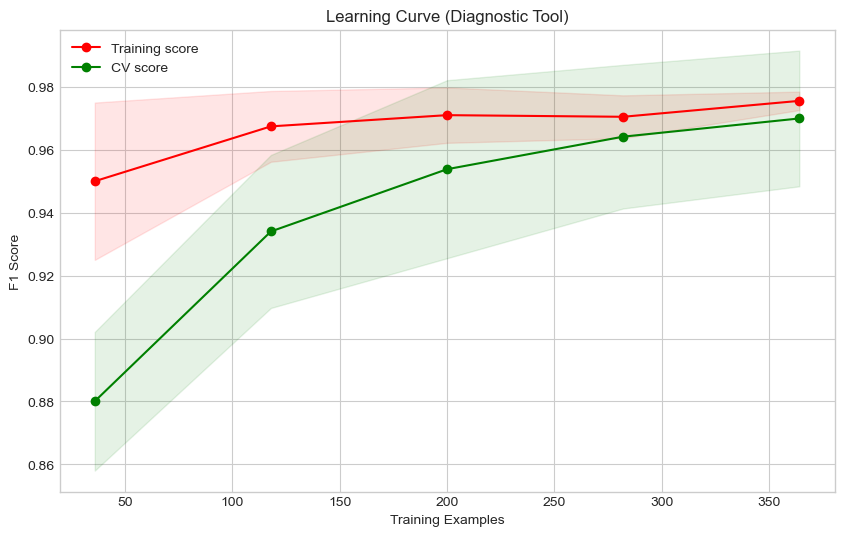

In [17]:

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="CV score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.title("Learning Curve (Diagnostic Tool)")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()



## 6. 결정 경계 시각화 (Decision Boundary via PCA)
로지스틱 회귀가 데이터를 어떻게 나누는지 직관적으로 보기 위해, 데이터를 2차원(PC1, PC2)으로 압축하여 결정 경계를 그려봅니다.
*주의: 실제 모델은 고차원에서 작동하지만, 이 시각화는 모델의 선형 분리 능력을 확인하기 위한 대리(Proxy) 분석입니다.*


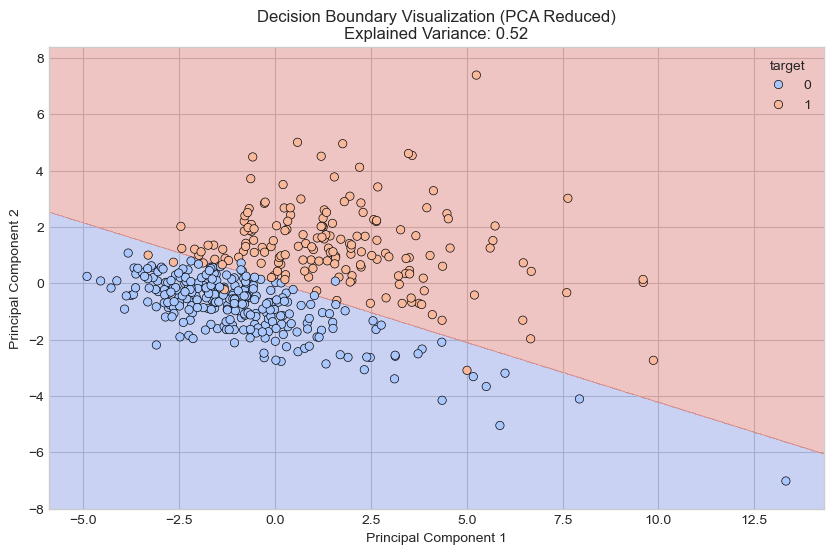

In [18]:

def plot_decision_boundary_pca(X, y):
    # 1. PCA로 2차원 축소
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

    # 2. 2차원 데이터로 간단한 로지스틱 회귀 학습 (시각화용)
    clf_pca = LogisticRegression(class_weight='balanced')
    clf_pca.fit(X_pca, y)

    # 3. Meshgrid 생성
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # 4. 예측 및 윤곽선 그리기
    Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', edgecolor='k')
    plt.title(f'Decision Boundary Visualization (PCA Reduced)\nExplained Variance: {np.sum(pca.explained_variance_ratio_):.2f}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_decision_boundary_pca(X_train, y_train)



## 7. 성과 평가 및 신뢰성 검증
### 7-1. 임계값(Threshold) 튜닝
의료 데이터에서 **False Negative(암을 놓침)**는 치명적입니다. 기본값 0.5 대신 Recall을 고려한 최적 임계값을 찾습니다.

### 7-2. Calibration Curve (확률 신뢰도)
모델이 내놓은 확률값(예: 70%)이 실제 리스크(70%)와 일치하는지 검증합니다.
- 점선(Perfectly Calibrated)에 가까울수록 신뢰성 높은 모델입니다.


Optimal Threshold: 0.5161


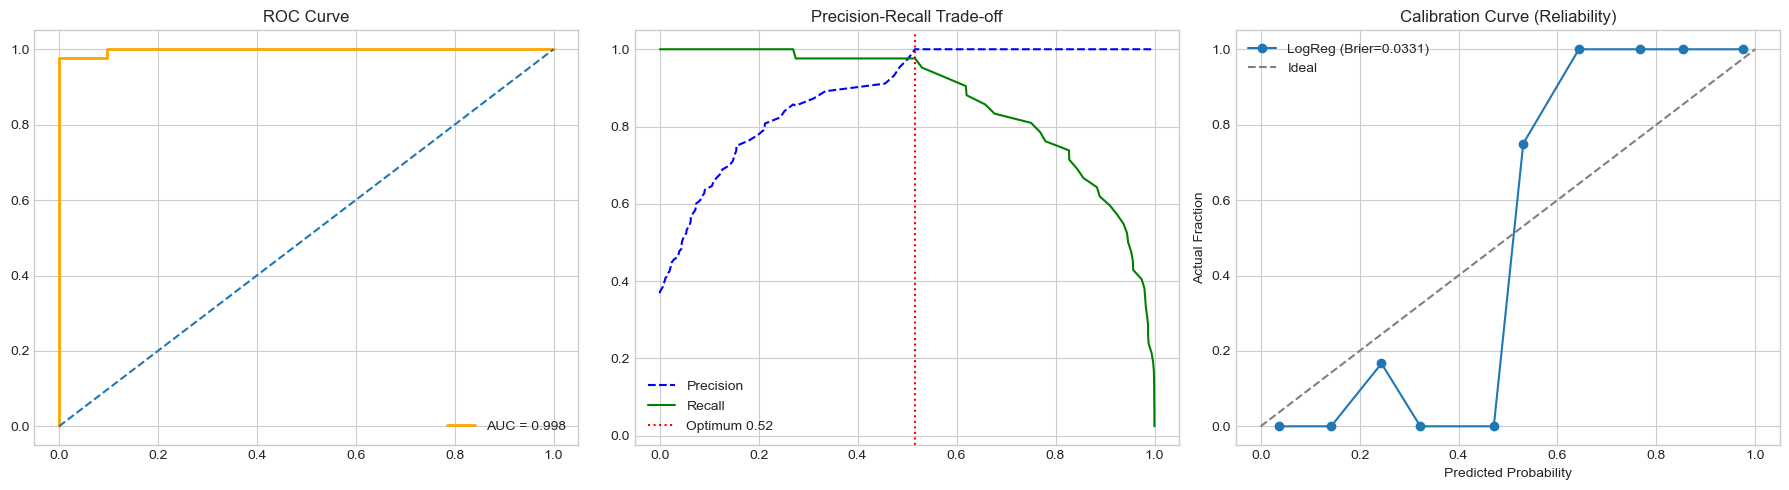

In [19]:

y_prob = best_model.predict_proba(X_test)[:, 1]

# 1. Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
brier = brier_score_loss(y_test, y_prob)

# 2. Threshold Tuning
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_thresh = thresholds[np.nanargmax(f1_scores)]

print(f"Optimal Threshold: {best_thresh:.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], linestyle='--')
axes[0].set_title('ROC Curve')
axes[0].legend()

# Precision-Recall Curve
axes[1].plot(thresholds, precisions[:-1], 'b--', label='Precision')
axes[1].plot(thresholds, recalls[:-1], 'g-', label='Recall')
axes[1].axvline(best_thresh, color='r', linestyle=':', label=f'Optimum {best_thresh:.2f}')
axes[1].set_title('Precision-Recall Trade-off')
axes[1].legend()

# Calibration Curve
axes[2].plot(prob_pred, prob_true, marker='o', label=f'LogReg (Brier={brier:.4f})')
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
axes[2].set_title('Calibration Curve (Reliability)')
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Actual Fraction')
axes[2].legend()

plt.tight_layout()
plt.show()



## 8. 최종 해석: 표준화 계수와 승산비
이미 **StandardScaler**를 거쳤기 때문에, 아래 도출된 계수(Coefficient)는 곧 **표준화 계수(Standardized Coefficient)** 입니다.
즉, **"해당 변수가 1 표준편차만큼 증가할 때, Log-Odds가 얼마나 변하는가"** 를 나타냅니다.

- **Odds Ratio (승산비)**: $\exp(\beta)$
    - 수치가 1보다 크면: 암 발병 위험을 높이는 요인 (Risk Factor)
    - 수치가 1보다 작으면: 암 발병 위험을 낮추는 요인 (Protective Factor)


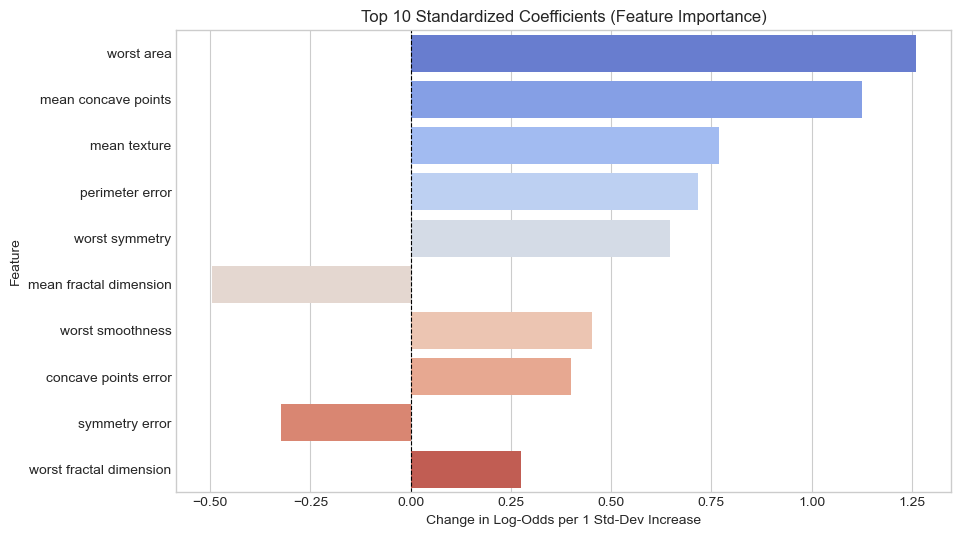

=== Top Risk Factors (Increase Cancer Probability) ===


,Feature,Std_Coefficient,Odds_Ratio,Abs_Importance
13,worst area,1.260828,3.528343,1.260828
2,mean concave points,1.125748,3.082521,1.125748
0,mean texture,0.769856,2.159455,0.769856
6,perimeter error,0.716923,2.048122,0.716923
15,worst symmetry,0.646777,1.909376,0.646777



=== Final Prediction Report (Optimized Threshold) ===
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        72
   Malignant       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [20]:

coefs = best_model.named_steps['clf'].coef_[0]
feature_names = X_train.columns

results_df = pd.DataFrame({
    'Feature': feature_names,
    'Std_Coefficient': coefs, # 이미 스케일링 되었으므로 표준화 계수임
    'Odds_Ratio': np.exp(coefs)
})
results_df['Abs_Importance'] = results_df['Std_Coefficient'].abs()
results_df = results_df.sort_values(by='Abs_Importance', ascending=False)

# 상위 10개 변수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Std_Coefficient', y='Feature', data=results_df.head(10), palette='coolwarm')
plt.title('Top 10 Standardized Coefficients (Feature Importance)')
plt.xlabel('Change in Log-Odds per 1 Std-Dev Increase')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.show()

print("=== Top Risk Factors (Increase Cancer Probability) ===")
display(results_df[results_df['Std_Coefficient'] > 0].head(5))

print("\n=== Final Prediction Report (Optimized Threshold) ===")
y_pred_opt = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_opt, target_names=['Benign', 'Malignant']))


In [21]:
# 1. Load Data (All Features)
data_full = load_breast_cancer()
X_full = pd.DataFrame(data_full.data, columns=data_full.feature_names)
y_full = (data_full.target == 0).astype(int) # Malignant=1

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# 3. Model (No Feature Selection)
pipeline_full = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(
        solver='saga', 
        max_iter=5000, 
        random_state=42, 
        class_weight='balanced'
    ))
])

pipeline_full.fit(X_train, y_train)
y_pred = pipeline_full.predict(X_test)

print("=== Classification Report (All 30 Features) ===")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

=== Classification Report (All 30 Features) ===
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        72
   Malignant       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

